# **Tarea Canny**

***Nombre del Grupo:***

***Integrantes:***

El algoritmo de detección de bordes de ***Canny***, propuesto por John F. Canny en 1986, es uno de los métodos más utilizados para la detección de bordes. Su objetivo principal es identificar los contornos más significativos dentro de una imagen, preservando la localización y continuidad de los bordes.

**El método de Canny se basa en una serie de pasos secuenciales**:

1.  Reducción de ruido mediante la **aplicación de un filtro Gaussiano**.

2.  **Cálculo del gradiente de intensidad** para detectar zonas de cambio abrupto en la imagen.

3. **Supresión no máxima**, que afina los bordes al eliminar respuestas no significativas en el gradiente.

4. **Umbralización con histéresis**, que ayuda a conectar bordes débiles que estén relacionados con bordes fuertes, mejorando así la continuidad del contorno.
    
La gran diferencia con metodos anteriores es que **toma en cuenta que los bordes deberian ser lineas mayormente conectadas**, dando mejores resultados que simplemente tomar un enfoque matematico.


## ***2) Calculo del gradiante de Intensidad***

Como ya hemos visto en clase, para conseguir una aproximacion del gradiante de una imagen, utilizamos operadores como Roberts, Sobel, Prewitt que intentan calcular una derivada discreta sobre los pixeles.

El gradiante no solo nos da informacion de la magnitud del cambio (a lo que nos hemos concentrado hasta ahora), sino tambien informacion sobre su **direccion**. Recordemos que la direccion del gradiante es ortogonal a la direccion del borde:




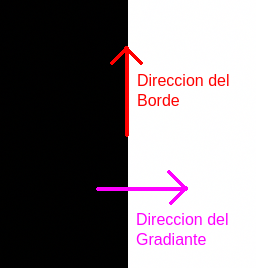

**Canny utilizara fuertemente la direccion del gradiante para diferenciar a que borde pertenece cada pixel**, por lo que sera necesaria guardarla.

Recoredemos que la **Magnitud** y la **direccion** son dadas por:

$$Magnitur:|f(n,m)| = \sqrt{f_x(n,m)^2 + f_y(n,m)^2}$$

$$Direccion: Θ(n,m) =  arctan2(f_y(n,m), f_x(n,m))$$

***Ejercicio Implementacion***: Dada una imagen, devuelvan la magnitud del gradiante y su direccion para cada pixel.

Dada una imagen y un sigma, deben aplicarle un Filtro Gaussiano y devolver 2 matrices con la magnitud y la direccion de cada pixel (Utilizen la funcion `filters.gaussian` para esto, el operador Sobel y `numpy.arctan2`)



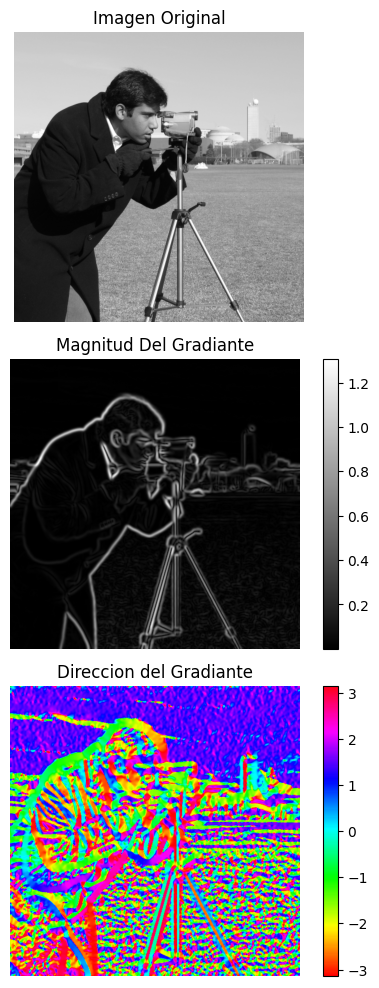

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import skimage
from skimage.data import camera
from skimage.filters import gaussian
from skimage.util import img_as_float32

def getMagnitudDireccion(imagen, sigma):

  imagen_suavizada = skimage.filters.gaussian(imagen, sigma=sigma)

  mascara_horizontal = np.array([[-1, 0, 1],
                                 [-2, 0, 2],
                                 [-1, 0, 1]])

  mascara_vertical = np.array([[1, 2, 1],
                               [0, 0, 0],
                               [-1, -2, -1]])

  Gx = ndimage.convolve(imagen_suavizada, mascara_horizontal)
  Gy = ndimage.convolve(imagen_suavizada, mascara_vertical)

  magnitud_gradiente = np.sqrt(Gx**2 + Gy**2)
  orientacion_gradiente = np.arctan2(Gy, Gx)

  return magnitud_gradiente, orientacion_gradiente

imagen = img_as_float32(camera())

# Calculamos la Magnitud y la direccion de cada punto de la imagen
magnitud, direccion = getMagnitudDireccion(imagen,2)

fig, axs = plt.subplots(3,1, figsize=(5,10))

axs[0].imshow(imagen, cmap='gray', clim=(0,1))
axs[0].set_title("Imagen Original")
axs[0].axis("off")

magPlot = axs[1].imshow(magnitud,cmap='gray')
axs[1].set_title(f"Magnitud Del Gradiante")
axs[1].axis("off")
fig.colorbar(magPlot)

dirPlot = axs[2].imshow(direccion, cmap='hsv', clim=(-np.pi,np.pi))
axs[2].set_title(f"Direccion del Gradiante")
axs[2].axis("off")
fig.colorbar(dirPlot)
# Visualisamos la imagen de dirección de gradiente utilizando un mapa de colores cíclico ('hsv')

plt.tight_layout()
plt.show()

## ***3) Supresión no máxima***
Una buena representacion de los bordes de una imagen deberia ser los mas fina posible, ya que **un borde representa un momento critico de cambio**. El tener bordes difusos significaria no conocer precisamente el momento de cambio en una imagen, se obtiene menos informacion.

Afortunadamente, **Canny** devuelve bordes de 1 pixel de ancho gracias al paso de la ***Supresión no máxima***


La **Supresión no máxima** busca eliminar todos los pixeles que no pertenecen a la linea principal del borde. Utilizando la direccion del grandel en un pixel, sabemos con cuales de sus vecinos hay que compararlo.

Por ejemplo, supongamos que tenemos las siguiente magnitudes de grandiante:

$$
\begin{bmatrix}
0.1 & 0.3 & 0.6 \\
0.2 & \textbf{0.4} & 0.7 \\
0.2 & 0.3 & 0.9 \\
\end{bmatrix}
$$

Gracias a la direccion, conocemos que el pixel central tiene una **direccion de 0 grados**, por lo que debe formar parte de un **borde vertical**. Para conocer si el pixel es parte de la linea principal, habria que comparar su valor con los pixeles cercanos que podrian formar parte de un borde en la misma direccion. En este caso sus vecinos horizontales.

$$
\begin{bmatrix}
0.1 & 0.3 & 0.6 \\
\textbf{0.2} & \textbf{0.4} & \textbf{0.7} \\
0.2 & 0.3 & 0.9 \\
\end{bmatrix}
$$

Ya que su magnitud no es la mayor, suprimimos el valor.

$$
\begin{bmatrix}
0.1 & 0.3 & 0.6 \\
0.2 & \textbf{0} & 0.7 \\
0.2 & 0.3 & 0.9 \\
\end{bmatrix}
$$

Por otro lado, si hubiera sido el mayor, mantendria su valor para el siguiente paso.



Con esta idea, clasificaremos cada direccion en 4 categorias segun con cuales vecinos se tendra que comparar:

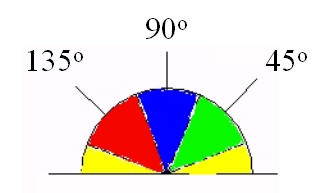

*   Si el gradiante redondeado es **0°** (**Amarillo**) (El Borde esta en direccion **Norte - Sur**), el pixel sera considerado borde si su magnitud es mayor que sus vecinos del **Este y Oeste**.

*   Si el gradiante redondeado es **90°** (**Azul**) (El Borde esta en direccion **Este - Oeste**), el pixel sera considerado borde si su magnitud es mayor que sus vecinos del **Sur y Norte**.

*   Si el gradiante redondeado es **135°** (**Rojo**) (El Borde esta en direccion **NorEste - SurOeste**), el pixel sera considerado borde si su magnitud es mayor que sus vecinos del **NorOeste - SurEste**.

*   Si el grandiante redondeado es **45°** (**Verde**) (El Borde esta en direccion **NorOeste - SurEste**), el pixel sera considerado borde si su magnitud es mayor que sus vecinos del **NorEste - SurOeste**.

    

### ***Ejercicio:*** Implementar el algoritmo de supresion no maxima.
Dada una imagen y un sigma, devolver la magnitud del gradiante de la imagen con todos los valores que no cumplan el criterio de maxima en 0.



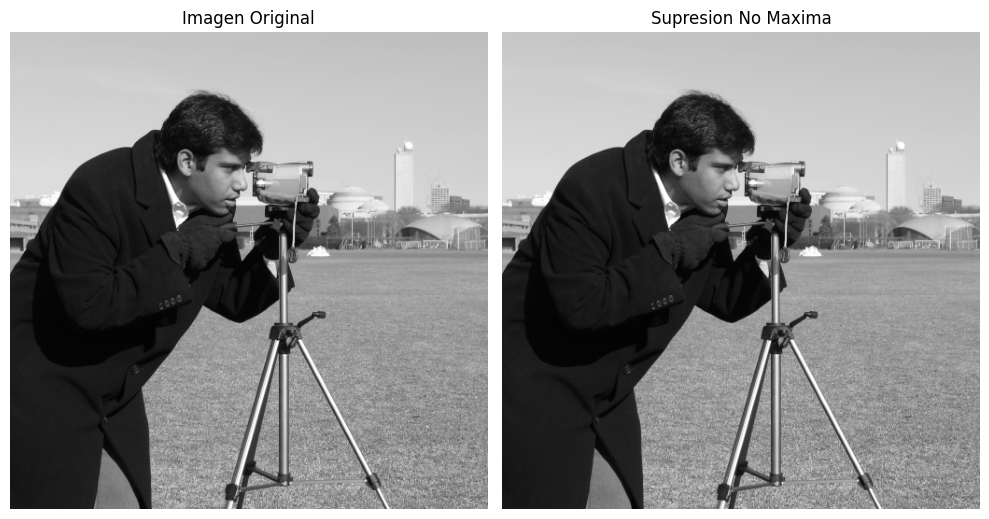

In [ ]:
#Dado un angulo en radianes, devuelve a cual de las 4 clasificaciones pertenece
def clasificacionDireccion(direccion):
  direccionGrados = direccion * 180. / np.pi
  # Si es negativa, la damos vuelta
  if direccionGrados < 0:
    direccionGrados += 180

    #Angulo 0
    if (0 <= direccionGrados < 22.5) or (157.5 <= direccionGrados <= 180):
      return 0

    #angle 45
    elif (22.5 <= direccionGrados < 67.5):
      return 1

    #angle 90
    elif (67.5 <= direccionGrados < 112.5):
      return 2

    #angle 135
    elif (112.5 <= direccionGrados < 157.5):
      return 3

def supresionNoMaxima(imagen, sigma):
  # COMPLETAR
  return imagen.copy()

imagen = img_as_float32(camera())

# Obtenemos una imagen con los maximos locales de cada tira de borde
maximosLocales = supresionNoMaxima(imagen,2)

fig, axs = plt.subplots(1,2, figsize=(10,10))

axs[0].imshow(imagen, cmap='gray', clim=(0,1))
axs[0].set_title("Imagen Original")
axs[0].axis("off")

axs[1].imshow(maximosLocales,cmap='gray')
axs[1].set_title(f"Supresion No Maxima")
axs[1].axis("off")

plt.tight_layout()
plt.show()




## ***4) Umbralización con histéresis***

Si a los pasos anteriores le agregaramos un umbral sobre los valores finales, ya tendriamos un detector de bordes bastante robusto y preciso, pero tendria el mismo problema que el resto de metodos, **sufrir de falsos positivos**.

Si eligieramos un umbral muy excluyente, e**ntonces seria tan exigente que perderiamos la mayoria de puntos validos**, terminando con una linea discontinua para representar los bordes. Por otro lado, si bajamos el umbral, **tendremos varios falsos positivos en nuestro resultado final**.

Para resolver este problema, el algoritmo de Canny utilizara dos umbrales, uno fuerte y otro debil. Los pixeles que superen el umbral fuerte, seran considerados bordes instantaneamente, por otro lado, **los pixeles que solo superen en umbral debil solo seran considerados bordes si son vecino de un pixel fuerte**.

De esta forma evadimos los falsos positivos pero mantenemos la conectividad de los bordes finales.

Por ejemplo, supongan que tenemos el Umbral Fuerte 1 y el Debil 0.5 con la matriz:

$$
\begin{bmatrix}
0 & 0 & 0.6 & 0.2\\
0 & 2 & 0 & 0.7 \\
0 & 0.5 & 0.1 & 0 \\
2 & 0.3 & 0.5 & 0 \\
\end{bmatrix}
$$

Los pixeles fuertes que seran considerados bordes inmediatamente seran:

$$
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 \\
\end{bmatrix}
$$

Mientras que los pixeles debiles seran:

$$
\begin{bmatrix}
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
\end{bmatrix}
$$

Finalmente, los unicos que seran considerados bordes por tener un vecino fuerte seran:

$$
\begin{bmatrix}
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0 \\
0 & 1 & 0 & 0 \\
1 & 0 & 0 & 0 \\
\end{bmatrix}
$$


### ***Ejercicio***: Implementar Umbralización con Histéresis
Dada una imagen, sigma, un umbral fuerte y uno debil, implementar el algoritmo de Canny con **Umbralización con Histéresis**

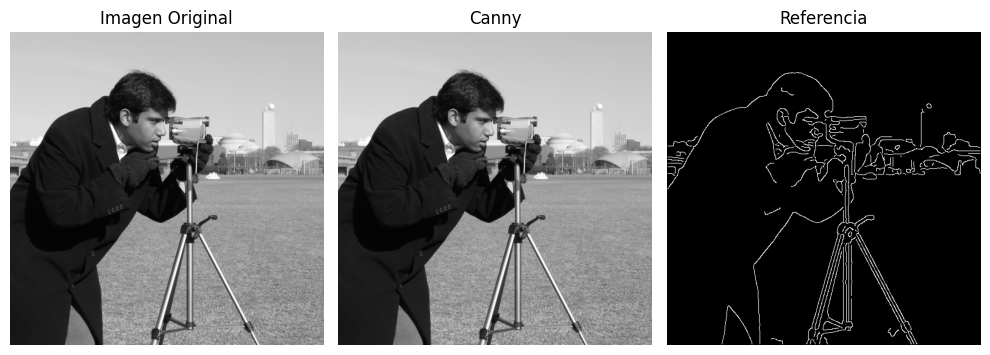

In [ ]:
from skimage.feature import canny

def Canny(imagen, sigma, umbralDebil, umbralFuerte):
  #COMPLETAR
  return imagen.copy()

imagen = img_as_float32(camera())

# Aplicamos Canny sobre la imagen.
cannyImagen = Canny(imagen,2,0.1,0.2)

# Usamos la implementacion oficial como referencia
cannySki = canny(imagen, sigma=2.0, low_threshold=0.1, high_threshold=0.2)

fig, axs = plt.subplots(1,3, figsize=(10,10))

axs[0].imshow(imagen, cmap='gray', clim=(0,1))
axs[0].set_title("Imagen Original")
axs[0].axis("off")

axs[1].imshow(cannyImagen,cmap='gray')
axs[1].set_title(f"Canny")
axs[1].axis("off")

axs[2].imshow(cannySki,cmap='gray')
axs[2].set_title(f"Referencia")
axs[2].axis("off")

plt.tight_layout()
plt.show()
